Pierre-Elliott THIBOUD  
Julien PERIER-CAMBY  

# IBI - TP1
## Partie 1

In [1]:
import gzip # pour décompresser les données
import pickle # pour désérialiser les données
import numpy as np # pour pouvoir utiliser des matrices
import matplotlib.pyplot as plt # pour l'affichage
import torch,torch.utils.data
from tqdm import tqdm_notebook as tqdm

In [2]:
def affichage(image,label):
    # on récupère à quel chiffre cela correspond (position du 1 dans label)
    label = np.argmax(label)
    # on crée une figure
    plt.figure()
    # affichage du chiffre
    # le paramètre interpolation='nearest' force python à afficher chaque valeur de la matrice sans l'interpoler avec ses voisines
    # le paramètre cmap définit l'échelle de couleur utilisée (ici noire et blanc)
    plt.imshow(image.reshape((28,28)),interpolation='nearest',cmap='binary')
    # on met un titre
    plt.title('chiffre '+str(label))
    # on affichage les figures créées
    plt.show()

### Chargement des données

In [3]:
TRAIN_BATCH_SIZE = 1

data = pickle.load(gzip.open('mnist.pkl.gz'),encoding='latin1')

train_data = torch.Tensor(data[0][0])
# labels de la base d'apprentissage
train_data_label = torch.Tensor(data[0][1])
# images de la base de test
test_data = torch.Tensor(data[1][0])
# labels de la base de test
test_data_label = torch.Tensor(data[1][1])
# on crée la base de données d'apprentissage (pour torch)
train_dataset = torch.utils.data.TensorDataset(train_data,train_data_label)
# on crée la base de données de test (pour torch)
test_dataset = torch.utils.data.TensorDataset(test_data,test_data_label)
# on crée le lecteur de la base de données d'apprentissage (pour torch)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=TRAIN_BATCH_SIZE, shuffle=True)
# on crée le lecteur de la base de données de test (pour torch)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False)

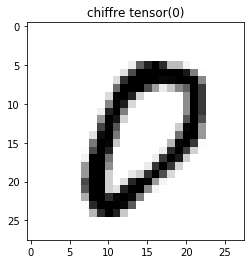

In [4]:
affichage(train_data[0], train_data_label[0])

### Paramètres

In [13]:
input_dim = 784
nb_class = 10

learning_rate = 1e-2

In [23]:
class Perceptron:
    def __init__(self, input_dim, output_dim, learning_rate):
        self.weights = np.random.normal(loc=0.0,scale=1.0,size=(output_dim,input_dim+1))
        self.learning_rate = learning_rate

    def forward(self, x):
        # Return output
        x = np.append(x.flatten(),1)
        return np.dot(self.weights, x)

    def backward(self, x, y, t):
        error = np.array(t) - y
        # Rajoute le biais
        x = np.append(np.array(x).flatten(), 1)
        
        delta = x.reshape(785,1).dot(error.reshape(1,10)) * self.learning_rate
        
        # Mise à jour des poids
        self.weights += delta.T

In [24]:
model = Perceptron(input_dim, nb_class,; learning_rate)

def training(model, epochs):
    for epoch in range(epochs):
        for (idx,(image,label)) in enumerate(train_loader):
            # on demande les prochaines données de la base
            y = model.forward(image)
            model.backward(image, y, label)
            
training(model, 1)

In [25]:
def test(model):
    true_positives = 0
    for (idx,(image,label)) in enumerate(test_loader):
        if np.argmax(label.numpy()) == np.argmax(model.forward(image)):
            true_positives += 1
    print("Accuracy: ", true_positives/len(test_loader))
    
test(model)

Accuracy:  0.521


### Grid search

In [29]:
learning_rates = (1e-3, 1e-2, 0.1)

for lr in learning_rates:
    print("------------------\nLearning rate :", lr)
    model = Perceptron(nb_class, input_dim, lr)
    
    for k in range(1,6):
        training(model, 5)
        print("Epoch", k*5, ": ", end='')
        test(model)
    

------------------
Learning rate : 0.001
Epoch 5 :Accuracy:  0.6071428571428571
Epoch 10 :Accuracy:  0.7398571428571429
Epoch 15 :Accuracy:  0.7882857142857143
Epoch 20 :Accuracy:  0.8074285714285714
Epoch 25 :Accuracy:  0.8171428571428572
------------------
Learning rate : 0.01
Epoch 5 :Accuracy:  0.693
Epoch 10 :Accuracy:  0.7001428571428572
Epoch 15 :Accuracy:  0.6814285714285714
Epoch 20 :Accuracy:  0.6928571428571428
Epoch 25 :Accuracy:  0.6978571428571428
------------------
Learning rate : 0.1
Epoch 5 :Accuracy:  0.09785714285714285
Epoch 10 :Accuracy:  0.09785714285714285
Epoch 15 :Accuracy:  0.09785714285714285
Epoch 20 :Accuracy:  0.09785714285714285
Epoch 25 :Accuracy:  0.09785714285714285


## Shallow Nerwork

In [ ]:
class MLP:
    def __init__(self, nb_class, input_dim, nb_neurons):
        self.hidden_layer = Perceptron(input_dim, nb_neurons)
        self.output_layer = Perceptron(nb_neurons, nb_class)
        self.hidden_output = None
        
    def forward(self, x):
        yi = self.hidden_layer.forward(x)
        self.hidden_output = 1/(1 + np.exp(-np.sum(yi)))
            
        return self.output_layer.forward(self.hidden_output)
    
    def backward(self, x, y ,t):
        output_error = np.array(t) - y
        self.hidden_output*(1-self.hidden_output)*np.sum(self.output_layer.weights.dot())